In [58]:
# import 
import networkx as nx
import osmnx as ox
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import LineString

import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from matplotlib import pyplot as plt

In [2]:
# predefined
city = 'zurich'

#### 检测器

In [3]:
# 检测器数据
detectors = pd.read_csv("UTD19/detectors_public.csv").query("citycode == @city")
detectors = gpd.GeoDataFrame(detectors,geometry=gpd.points_from_xy(detectors.long,detectors.lat))
detectors.crs = "EPSG:4326"

In [4]:
# 检测器个数
pd.read_csv("UTD19/detectors_public.csv").citycode.value_counts()

citycode
london         5719
tokyo          1887
losanageles    1725
melbourne      1630
madrid         1116
utrecht        1072
zurich         1020
bern            755
augsburg        717
vilnius         581
bremen          548
munich          520
kassel          513
toulouse        478
taipeh          445
bordeaux        438
hamburg         419
torino          399
darmstadt       392
graz            300
stuttgart       298
rotterdam       259
paris           247
santander       219
toronto         188
speyer          184
manchester      181
marseille       169
bolton          166
luzern          158
strasbourg      142
wolfsburg       133
constance       122
cagliari        122
frankfurt       112
basel            77
birmingham       66
groningen        55
essen            38
innsbruck        16
Name: count, dtype: int64

In [5]:
print(detectors.crs)

EPSG:4326


       detid    length       pos    fclass            road limit citycode  \
22606  K2D11  0.377599  0.015064   primary  Seebahnstrasse    50   zurich   
22607  K2D13  0.059272  0.014468  tertiary  Badenerstrasse    50   zurich   
22608  K2D14  0.161521  0.006782   primary  Seebahnstrasse    50   zurich   
22609  K2D15  0.158996  0.020170   primary  Seebahnstrasse    50   zurich   
22610  K2D16  0.156223  0.017910   primary  Seebahnstrasse    50   zurich   

       lanes  linkid      long        lat                  geometry  
22606    1.0  1128.0  8.518458  47.375536  POINT (8.51846 47.37554)  
22607    1.0   212.0  8.518211  47.375198  POINT (8.51821 47.37520)  
22608    1.0  1109.0  8.518765  47.374964  POINT (8.51877 47.37496)  
22609    1.0  1108.0  8.518818  47.374825  POINT (8.51882 47.37483)  
22610    1.0  1106.0  8.518857  47.374831  POINT (8.51886 47.37483)  


<Axes: >

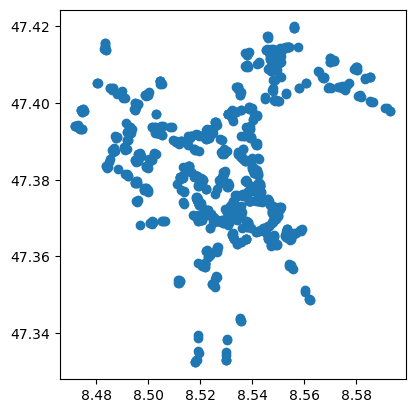

In [6]:
print(detectors.head())
detectors.plot()

#### 路网

In [7]:
links = pd.read_csv("UTD19/links.csv").query("citycode == @city")


In [8]:
print(links.head(10))


            long        lat  order  piece  linkid  group citycode
131433  8.543164  47.377691      1      1       0    0.1   zurich
131434  8.543140  47.377698      2      1       0    0.1   zurich
131435  8.542875  47.378197      3      1       0    0.1   zurich
131436  8.542758  47.378413      4      1       0    0.1   zurich
131437  8.542708  47.378511      5      1       0    0.1   zurich
131438  8.542624  47.378586      1      1       1    1.1   zurich
131439  8.542805  47.378233      2      1       1    1.1   zurich
131440  8.543108  47.377690      3      1       1    1.1   zurich
131441  8.543386  47.377156      4      1       1    1.1   zurich
131442  8.543408  47.377084      5      1       1    1.1   zurich


In [14]:
def agg_func(df):
    xy = df.sort_values("order").loc[:,["long","lat"]].values
    line = LineString(xy)
    return line
    
# links_gdf = links.concat(links.groupby('linkid').apply(agg_func))
# links_gdf.head(10)


#### 检测器数据

In [15]:
measurements = pd.read_csv("UTD19/utd19_u.csv",dtype={"detid":str}).query("city == @city")

In [16]:
print(measurements.head())


                  day  interval   detid  flow       occ  error    city  speed
130955369  2015-10-26       180  K10D11  40.0  0.005556    0.0  zurich    NaN
130955370  2015-10-26       360  K10D11   0.0  0.000000    0.0  zurich    NaN
130955371  2015-10-26       540  K10D11  40.0  0.007778    0.0  zurich    NaN
130955372  2015-10-26       720  K10D11  40.0  0.008333    0.0  zurich    NaN
130955373  2015-10-26       900  K10D11   0.0  0.000000    0.0  zurich    NaN


In [41]:
measurements.detid.value_counts()

detid
K10D11     3359
K448D16    3359
K445D14    3359
K445D15    3359
K445D16    3359
           ... 
K321D11    3359
K321D13    3359
K321D14    3359
K8D20      3359
K218D21    2181
Name: count, Length: 1020, dtype: int64

In [55]:
m = measurements.query("detid == 'K10D11' and day == '2015-10-26'")
m.head(5)

,day,interval,detid,flow,occ,error,city,speed
130955369,2015-10-26,180,K10D11,40.0,0.005556,0.0,zurich,NaN
130955370,2015-10-26,360,K10D11,0.0,0.000000,0.0,zurich,NaN
130955371,2015-10-26,540,K10D11,40.0,0.007778,0.0,zurich,NaN
130955372,2015-10-26,720,K10D11,40.0,0.008333,0.0,zurich,NaN
130955373,2015-10-26,900,K10D11,0.0,0.000000,0.0,zurich,NaN


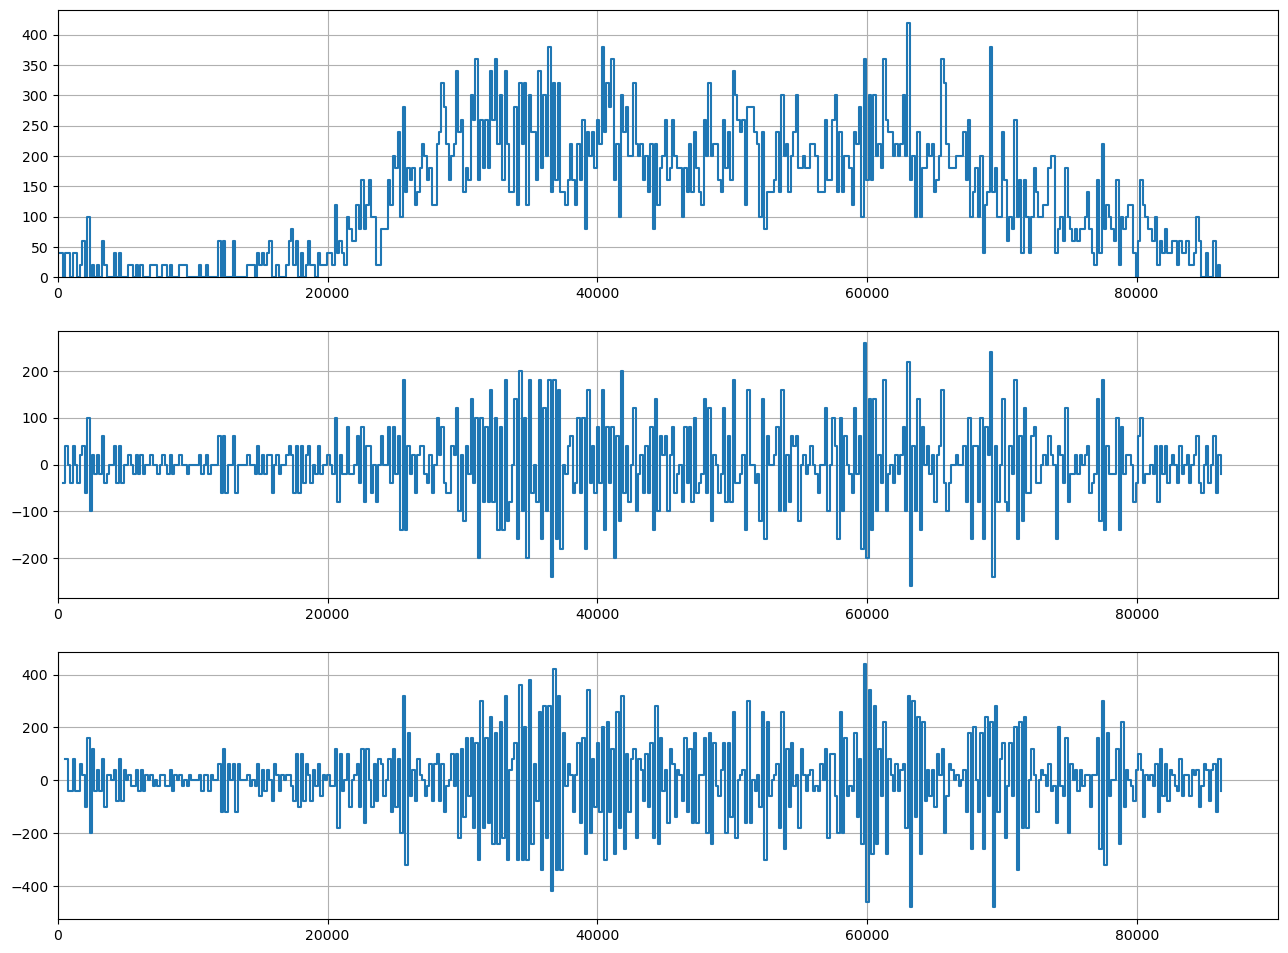

In [66]:
# flow
fig,axs = plt.subplots(3,1)
axs[0].step(m.interval,m.flow,where='post')
axs[0].set_ylim([0,None])
axs[0].set_xlim([0,None])
axs[0].grid()

axs[1].step(m.interval,m.flow.diff(1),where='post')
axs[1].set_xlim([0,None])
axs[1].grid()

axs[2].step(m.interval,m.flow.diff(1).diff(1),where='post')
axs[2].set_xlim([0,None])
axs[2].grid()

fig.set_size_inches(40/2.54,30/2.54)


In [74]:
# tsa
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(m.flow.diff(1).dropna(),lags=[i for i in range(1,12)],boxpierce=True)  # 差分后会出现nan，需要去除

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,218.131060,2.312356e-49,216.767741,4.586115e-49
2,305.812957,3.922475e-67,303.718955,1.117550e-66
3,405.885959,1.175417e-87,402.749530,5.618012e-87
4,473.419816,3.751807e-101,469.439214,2.722486e-100
5,531.903657,1.034198e-112,527.070166,1.143560e-111
6,594.115419,4.335625e-125,588.245065,8.001786e-124
7,650.426468,3.340969e-136,643.500282,1.038214e-134
8,701.824724,2.896413e-146,693.827740,1.525792e-144
9,749.163186,1.849761e-155,740.081363,1.662337e-153
10,800.406355,1.687450e-165,790.043452,2.850530e-163


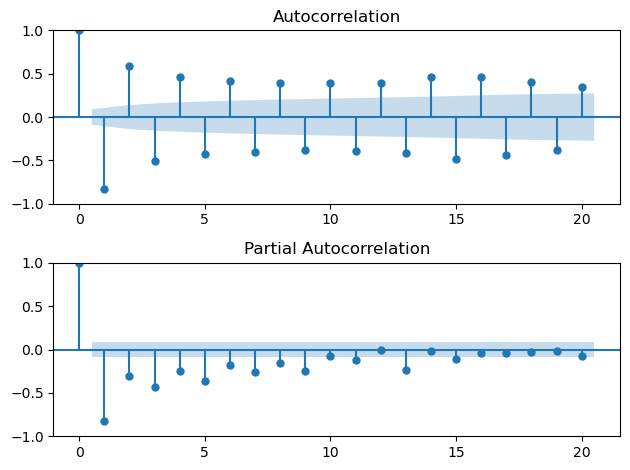

In [85]:
fig,axs = plt.subplots(2,1)
_ = sm.graphics.tsa.plot_acf(m.flow.diff(1).dropna(),lags=20,ax=axs[0])
_ = sm.graphics.tsa.plot_pacf(m.flow.diff(1).dropna(),lags=20,ax=axs[1])
fig.tight_layout()

In [ ]:
# smoothen
# exponential
def rwes(array):
    pass
# fourier
def fs(array):
    pass

(0.0, 90522.0)

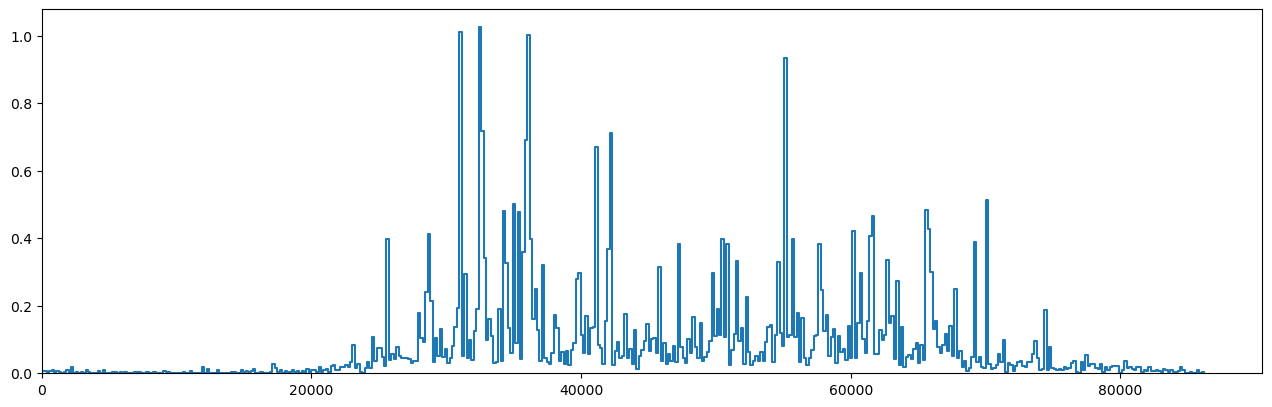

In [57]:
# occ
fig,ax = plt.subplots()
ax.step(m.interval,m.occ,where='post')
fig.set_size_inches(40/2.54,12/2.54)
ax.set_ylim([0,None])
ax.set_xlim([0,None])

(0.0, 90531.0)

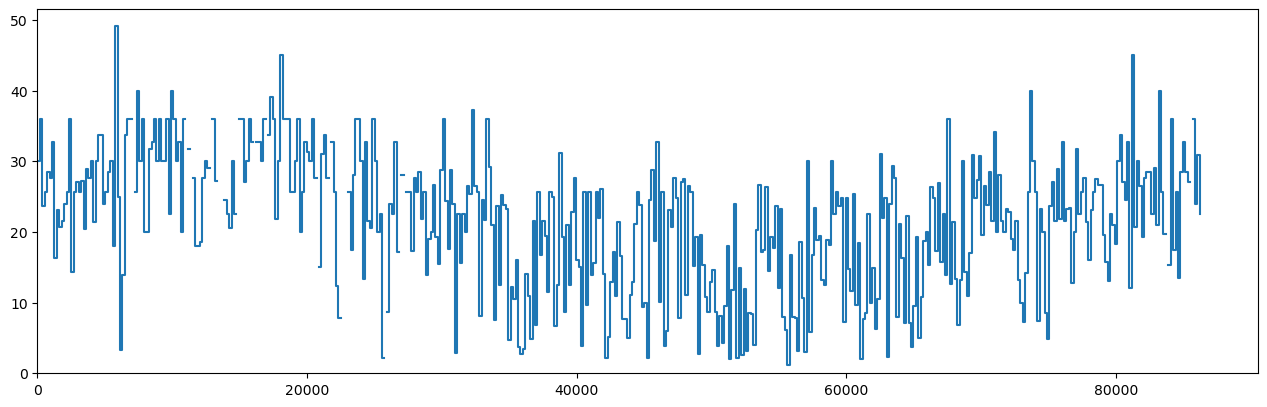

In [54]:
# speed
fig,ax = plt.subplots()
ax.step(m.interval,m.flow/((m.occ)/0.005),where='post')
fig.set_size_inches(40/2.54,12/2.54)
ax.set_ylim([0,None])
ax.set_xlim([0,None])

##### *tokyo检测器记录缺失

In [11]:
print(pd.read_csv("UTD19/detectors_public.csv").citycode.value_counts().shape)
print(pd.read_csv("UTD19/links.csv").citycode.value_counts().shape)
print(measurements.city.value_counts().shape)

(40,)
(40,)
(39,)
